# **CLUSTERING**



# **Imports**
Este código importa las bibliotecas necesarias para realizar análisis de datos, visualización, preprocesamiento y clustering en Python.

### **Importación de bibliotecas**

- **`pandas`**: Biblioteca para la manipulación y análisis de datos estructurados en forma de tablas (DataFrames).  
- **`numpy`**: Biblioteca para cálculos numéricos y manipulación de arreglos multidimensionales.  
- **`matplotlib.pyplot`**: Herramienta para crear visualizaciones gráficas (gráficos de líneas, barras, dispersión, etc.).  
- **`seaborn`**: Biblioteca basada en `matplotlib` que facilita la creación de visualizaciones estadísticas avanzadas.  
- **`warnings.filterwarnings('ignore')`**: Suprime las advertencias para evitar distracciones durante la ejecución del código.  

### **Preprocesamiento de datos**

- **`MinMaxScaler`**: Escala las características en un rango específico (por defecto, entre 0 y 1), útil para algoritmos sensibles a la escala de los datos.  
- **`Pipeline`**: Permite encadenar múltiples pasos de preprocesamiento y modelado en una secuencia estructurada.  

### **Algoritmos de clustering**

Se importan varios algoritmos de clustering para agrupar datos según patrones similares:

- **`KMeans`**: Algoritmo basado en centroides que particiona los datos en K grupos.  
- **`DBSCAN`**: Algoritmo basado en densidad, útil para detectar clusters de formas arbitrarias y manejar ruido.  
- **`AgglomerativeClustering`**: Algoritmo jerárquico que agrupa los datos mediante un enfoque de fusión ascendente.  
- **`MeanShift`**: Algoritmo basado en estimación de densidad que encuentra clusters sin necesidad de especificar el número de grupos.  
- **`GaussianMixture`**: Modelo probabilístico basado en la combinación de múltiples distribuciones gaussianas para identificar clusters.  

### **Evaluación y optimización de modelos**

- **`GridSearchCV`**: Herramienta para realizar la búsqueda de hiperparámetros óptimos mediante validación cruzada.  
- **`silhouette_score`**: Métrica de evaluación que mide la calidad del agrupamiento en términos de cohesión y separación de clusters.  
- **`make_scorer`**: Convierte una métrica en un formato compatible con `GridSearchCV` para optimización de modelos.  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer, rand_score, v_measure_score
from sklearn.decomposition import PCA

# **Preproceso del Dataset**
El código realiza la carga y preprocesamiento de datos de calidad del aire desde un archivo CSV.

### **Carga de datos**  
Se carga el archivo de datos utilizando la librería `pandas`, especificando el delimitador adecuado para su correcta interpretación.

### **Conversión de fechas y creación de variables derivadas**  
Se convierten las columnas de fecha a un formato de fecha y hora adecuado. Luego, se extraen componentes como el día, mes y año, creando nuevas columnas con estos valores.  

### **Conversión de la columna de hora**  
Se transforma la columna de tiempo en un formato de hora reconocible para facilitar su manipulación.

### **Mapeo de días de la semana**  
Se genera una nueva columna que almacena el nombre del día de la semana correspondiente a cada fecha y se convierte a valores numéricos utilizando un diccionario de mapeo.
Esta columna se crea para luego poder entrenar los modelos. Los números van del 0 al 6. 

### **Categorización por partes del día  columna `PeriodoDia`**
Se define una función que categoriza las horas en tres períodos del día:  
- **Mañana:** 6 AM - 12 PM  
- **Tarde:** 12 PM - 6 PM  
- **Noche:** 6 PM - 6 AM  

El rango es de 0 a 2 siendo la mañana 0, la tarde 1 y la noche 2.
Esta función se aplica a la columna de tiempo.

Esta columna se crea para luego poder entrenar los modelos. 

### **Reemplazo de caracteres y conversión de tipos de datos**  
Se reemplazan las comas por puntos en ciertas columnas para permitir la conversión a formato numérico de punto flotante.

### **Conversión de valores numéricos a enteros**  
Se verifica si las columnas numéricas contienen solo valores enteros y, en ese caso, se convierten al tipo de dato entero compatible con valores nulos.

### **Eliminación de columnas innecesarias**  
Se eliminan columnas irrelevantes o vacías que no aportan información útil para el análisis. 

Borramos `Unnamed: 15`, `Unnamed: 16`, `Time`. 

Las 2 primeras columnas se borrar porque estan vacias y la de `Time` la borramos porque la hora ya la tenemos con la columna `PeriodoDia`.

### **Limpieza de filas con valores faltantes**  
Se eliminan las filas donde todos los valores son nulos para mantener la calidad del dataset.

### **Visualización de información**  
Finalmente, se muestra la estructura del DataFrame, incluyendo los tipos de datos de cada columna y los primeros registros del conjunto de datos para su inspección.

In [5]:
# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Convertir las fechas y horas
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Crear las variables derivadas de 'Date'
df['Dia'] = df['Date'].dt.day
df['Mes'] = df['Date'].dt.month
df['Anio'] = df['Date'].dt.year

df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Mapear días de la semana a números
df['DiaSemana'] = df['Date'].dt.day_name()
dias_semana_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['DiaSemana'] = df['DiaSemana'].map(dias_semana_map)

# Categorizar por partes del día
def time_to_period(hour):
    if 6 <= hour < 12:
        return 0 #Mañana
    elif 12 <= hour < 18:
        return 1 #Tarde
    else:
        return 2 #Noche

df['PeriodoDia'] = df['Time'].apply(lambda t: time_to_period(t.hour) if pd.notnull(t) else None)

# Función para clasificar las estaciones
def mes_a_estacion(mes):
    if mes in [3, 4, 5]:
        return 0 #Primavera
    elif mes in [6, 7, 8]:
        return 1 #Verano
    elif mes in [9, 10, 11]:
        return 2 #Otoño
    else:
        return 3 #Invierno

# Aplicar la función para crear la columna de estación
df['Estacion'] = df['Mes'].apply(mes_a_estacion)


# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)


# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time'], errors='ignore')
# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df = df.dropna()

# Mostrar información y primeros registros
print("Tipos de datos:")
print(df.dtypes)
print("\nPrimeros registros:")
print(df.head())



Tipos de datos:
Date             datetime64[ns]
CO(GT)                  float64
PT08.S1(CO)               Int64
NMHC(GT)                  Int64
C6H6(GT)                float64
PT08.S2(NMHC)             Int64
NOx(GT)                   Int64
PT08.S3(NOx)              Int64
NO2(GT)                   Int64
PT08.S4(NO2)              Int64
PT08.S5(O3)               Int64
T                       float64
RH                      float64
AH                      float64
Dia                       Int64
Mes                       Int64
Anio                      Int64
DiaSemana                 Int64
PeriodoDia                Int64
Estacion                  Int64
dtype: object

Primeros registros:
        Date  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0 2004-03-10       3         1360       150        12           1046      166   
1 2004-03-10       2         1292       112         9            955      103   
2 2004-03-10       2         1402        88         9            9

# **Proceso de Limpieza y Preparación de Datos: Manejo de Valores Faltantes y Erróneos**

### **Lista de columnas a imputar**:  
   Se define una lista de columnas que contienen datos faltantes, representados como valores `NaN` o erróneos. Estas columnas son seleccionadas para ser procesadas en el análisis de imputación de datos.

### **Convertir columnas a tipo float**:  
   Se convierten las columnas seleccionadas a tipo `float` para garantizar que los datos sean tratados correctamente durante el proceso de imputación, evitando posibles errores por incompatibilidad de tipos de datos.

### **Reemplazar valores -200 con NaN**:  
   Se identifican los valores `-200` en las columnas seleccionadas, los cuales se consideran como valores erróneos o inválidos, y se reemplazan por `NaN` para que puedan ser tratados adecuadamente en el análisis.

### **Contar valores nulos antes de la eliminación**:  
   Se cuenta el número de valores nulos (representados como `NaN`) en las columnas seleccionadas antes de realizar cualquier operación de limpieza o imputación, proporcionando una visión de la cantidad de datos faltantes.

### **Calcular porcentaje de valores nulos**:  
   Se calcula el porcentaje de valores nulos en cada columna, lo que ayuda a entender la magnitud del problema de datos faltantes. Este porcentaje es clave para tomar decisiones sobre la imputación o eliminación de datos.

### **Eliminar la columna 'NMHC(GT)'**:  
   Se elimina la columna `'NMHC(GT)'` del DataFrame, ya que contiene un 90% de valores faltantes, lo que la hace inapropiada para el análisis. Al eliminarla, se mejora la calidad del conjunto de datos.

### **Actualizar la lista de columnas después de eliminar 'NMHC(GT)'**:  
   Se actualiza la lista de columnas a imputar (`imputar_nan`) para reflejar la eliminación de la columna `'NMHC(GT)'`, asegurando que el análisis se realice solo sobre las columnas relevantes.

### **Eliminar filas donde haya valores NaN en las columnas seleccionadas**:  
   Se eliminan las filas que contienen valores `NaN` en las columnas seleccionadas, ya que los datos faltantes en estas filas comprometen la calidad del análisis y la capacidad del modelo para realizar predicciones precisas.

### **Conclusión**
Durante el análisis del conjunto de datos, se identificó la presencia de valores erróneos registrados como -200, los cuales se interpretan como datos incorrectos. Para abordar este problema, dichos valores fueron reemplazados por `NaN` con el fin de evaluar la cantidad de datos faltantes en cada columna.  

Se detectó que la columna 'NMHC(GT)' presentaba un 90% de valores faltantes, por lo que se decidió eliminarla del conjunto de datos, ya que su alto nivel de ausencia compromete su utilidad para el análisis. En cuanto a las demás columnas, aunque presentan un porcentaje menor de valores faltantes, se observó que las filas con datos faltantes afectan múltiples variables simultáneamente. Debido a esto, se optó por eliminar las filas completas en lugar de intentar imputar valores, ya que la falta de información en varias variables dificulta la capacidad del modelo para realizar predicciones precisas.  

Se realizaron pruebas de imputación utilizando tanto la media como la mediana con el objetivo de evaluar cuál de estos métodos sería más adecuado. A través del análisis visual y exploratorio de los datos, se determinó que la mediana era la opción más óptima. Se observó que los datos presentaban una distribución asimétrica, lo que indicaba la presencia de valores atípicos que podrían distorsionar la media. La mediana, al ser menos sensible a estos valores extremos, ofreció una representación más robusta y precisa de la tendencia central. Sin embargo, debido a la presencia de valores faltantes en múltiples columnas de la misma fila, se concluyó que la mejor estrategia era eliminar dichas filas en lugar de imputarlas, garantizando así la calidad del conjunto de datos para su posterior análisis.


In [6]:
# Lista de columnas a imputar.
imputar_nan = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NMHC(GT)', 'NO2(GT)', 
               'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
               'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Convertir columnas a tipo float para evitar problemas de tipo de dato
df[imputar_nan] = df[imputar_nan].astype(float)

# Reemplazar valores -200 con NaN en las columnas seleccionadas
df[imputar_nan] = df[imputar_nan].replace(-200, np.nan)

# Contar valores nulos antes de la eliminación
valores_nulos = df[imputar_nan].isna().sum()

# Calcular porcentaje de valores nulos
porcentaje_nulos = (valores_nulos / len(df)) * 100

# Mostrar valores nulos antes de la eliminación
print("Valores faltantes por columna (antes de eliminación):")
print(valores_nulos)

print("\nPorcentaje de valores faltantes por columna:")
print(porcentaje_nulos.round(2).astype(str) + '%')

# Eliminar la columna 'NMHC(GT)' ya que tiene un 90% de valores faltantes
df = df.drop(columns=['NMHC(GT)'], errors='ignore')

# Actualizar la lista de columnas después de eliminar 'NMHC(GT)'
imputar_nan.remove('NMHC(GT)')

# Eliminar filas donde haya valores NaN en las columnas seleccionadas
df = df.dropna(subset=imputar_nan)

# Mostrar valores después de eliminar filas con valores nulos
print("\nValores faltantes por columna (después de eliminación):")
print(df.isna().sum())

# Mostrar las primeras filas del DataFrame después de limpieza
print("\nDataFrame después de eliminación de valores nulos:")
print(df.head())


Valores faltantes por columna (antes de eliminación):
CO(GT)           1683
C6H6(GT)          366
NOx(GT)          1639
NMHC(GT)         8443
NO2(GT)          1642
PT08.S1(CO)       366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

Porcentaje de valores faltantes por columna:
CO(GT)           17.99%
C6H6(GT)          3.91%
NOx(GT)          17.52%
NMHC(GT)         90.23%
NO2(GT)          17.55%
PT08.S1(CO)       3.91%
PT08.S2(NMHC)     3.91%
PT08.S3(NOx)      3.91%
PT08.S4(NO2)      3.91%
PT08.S5(O3)       3.91%
T                 3.91%
RH                3.91%
AH                3.91%
dtype: object

Valores faltantes por columna (después de eliminación):
Date             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH       

# **Análisis de Concentración Promedio de Gases por Día de la Semana y Periodo del Día**

### **Selección de Columnas de Interés**:
   - Se definen dos listas de columnas: `gases_media_semana`, que incluye los gases de interés y los periodos de día y semana, y `gases`, que se centra solo en los gases para los que se desea realizar un análisis gráfico.

### **Selección de Gases**:
   - Hemos elegido cuatro gases: 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', debido a que son altamente perjudiciales para la salud humana. Estos gases tienen un impacto significativo en la calidad del aire y la salud pública. Al enfocarnos en estos gases, el objetivo es entrenar modelos predictivos que nos ayuden a identificar los días de la semana y los periodos del día en los que la contaminación es menor, lo cual es fundamental para implementar estrategias de mejora de la calidad del aire.

### **Agrupación de Datos**:
   - El DataFrame se agrupa por el día de la semana (`DiaSemana`) y el periodo del día (`PeriodoDia`). Para cada grupo, se calcula la media de las concentraciones de los gases definidos en la lista `gases_media_semana`.
   - Los resultados se redondean a dos decimales y se almacenan en un nuevo DataFrame `df_grouped`.

### **Creación de Subgráficos**:
   - Se crea una figura con subgráficos para cada gas en la lista `gases`. El número de subgráficos es igual al número de gases que se desean graficar.
   - Para cada gas, se reorganizan los datos del DataFrame agrupado para que las concentraciones de gases sean representadas por día de la semana y periodo del día. Esta reorganización se realiza mediante un "pivot", donde las filas corresponden a los días de la semana y las columnas a los periodos del día.

### **Generación de los Gráficos**:
   - Para cada gas, se genera un gráfico de barras que muestra la concentración promedio por día y por periodo. Los ejes se etiquetan adecuadamente con el nombre del gas, el día de la semana y la concentración promedio.

### **Ajuste del Diseño**:
   - El diseño de la figura se ajusta para evitar que los subgráficos se superpongan, utilizando la función `plt.tight_layout()`.
   - Finalmente, se muestra el gráfico con `plt.show()`.

Este procedimiento permite visualizar la variación de las concentraciones de los gases a lo largo de la semana y durante los diferentes periodos del día, lo que facilita la identificación de patrones de contaminación y la planificación de intervenciones para mejorar la calidad del aire.

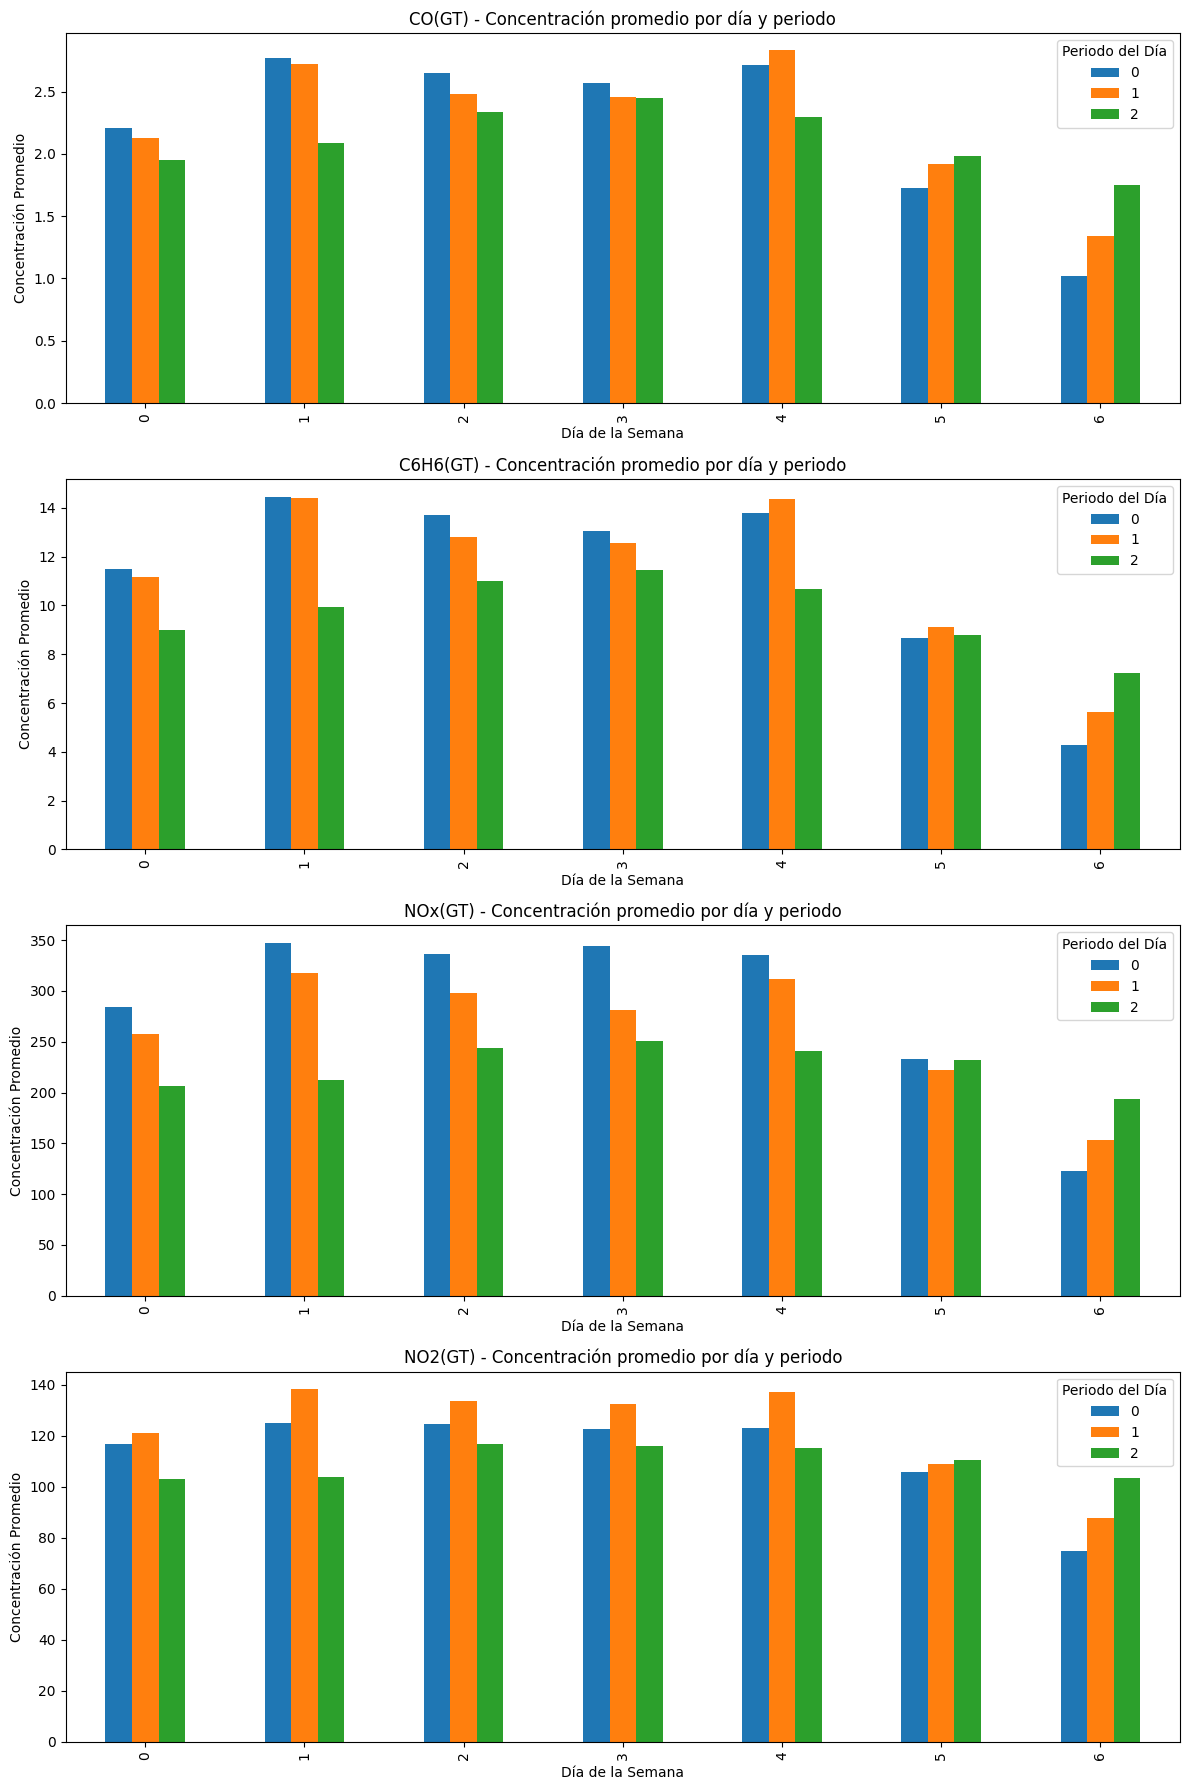

In [7]:

gases_media_semana = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PeriodoDia', 'DiaSemana']
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Agrupar por día de la semana y periodo del día, y calcular la media de cada gas
df_grouped = df[gases_media_semana].groupby(['DiaSemana', 'PeriodoDia']).mean().reset_index().round(2)

# Crear una figura con subgráficos para cada gas
fig, axes = plt.subplots(len(gases), 1, figsize=(12, 18))

for i, gas in enumerate(gases):
    # Reorganizar los datos para graficar
    gas_data = df_grouped.pivot(index='DiaSemana', columns='PeriodoDia', values=gas)
    gas_data.plot(kind='bar', ax=axes[i], legend=True)
    
    axes[i].set_title(f'{gas} - Concentración promedio por día y periodo')
    axes[i].set_xlabel('Día de la Semana')
    axes[i].set_ylabel('Concentración Promedio')
    axes[i].legend(title='Periodo del Día')

# Ajustar el diseño de la figura para evitar superposiciones
plt.tight_layout()
plt.show()


# HISTORIA 2 EN VERANO MENOS CONTAMINACIÓN ??



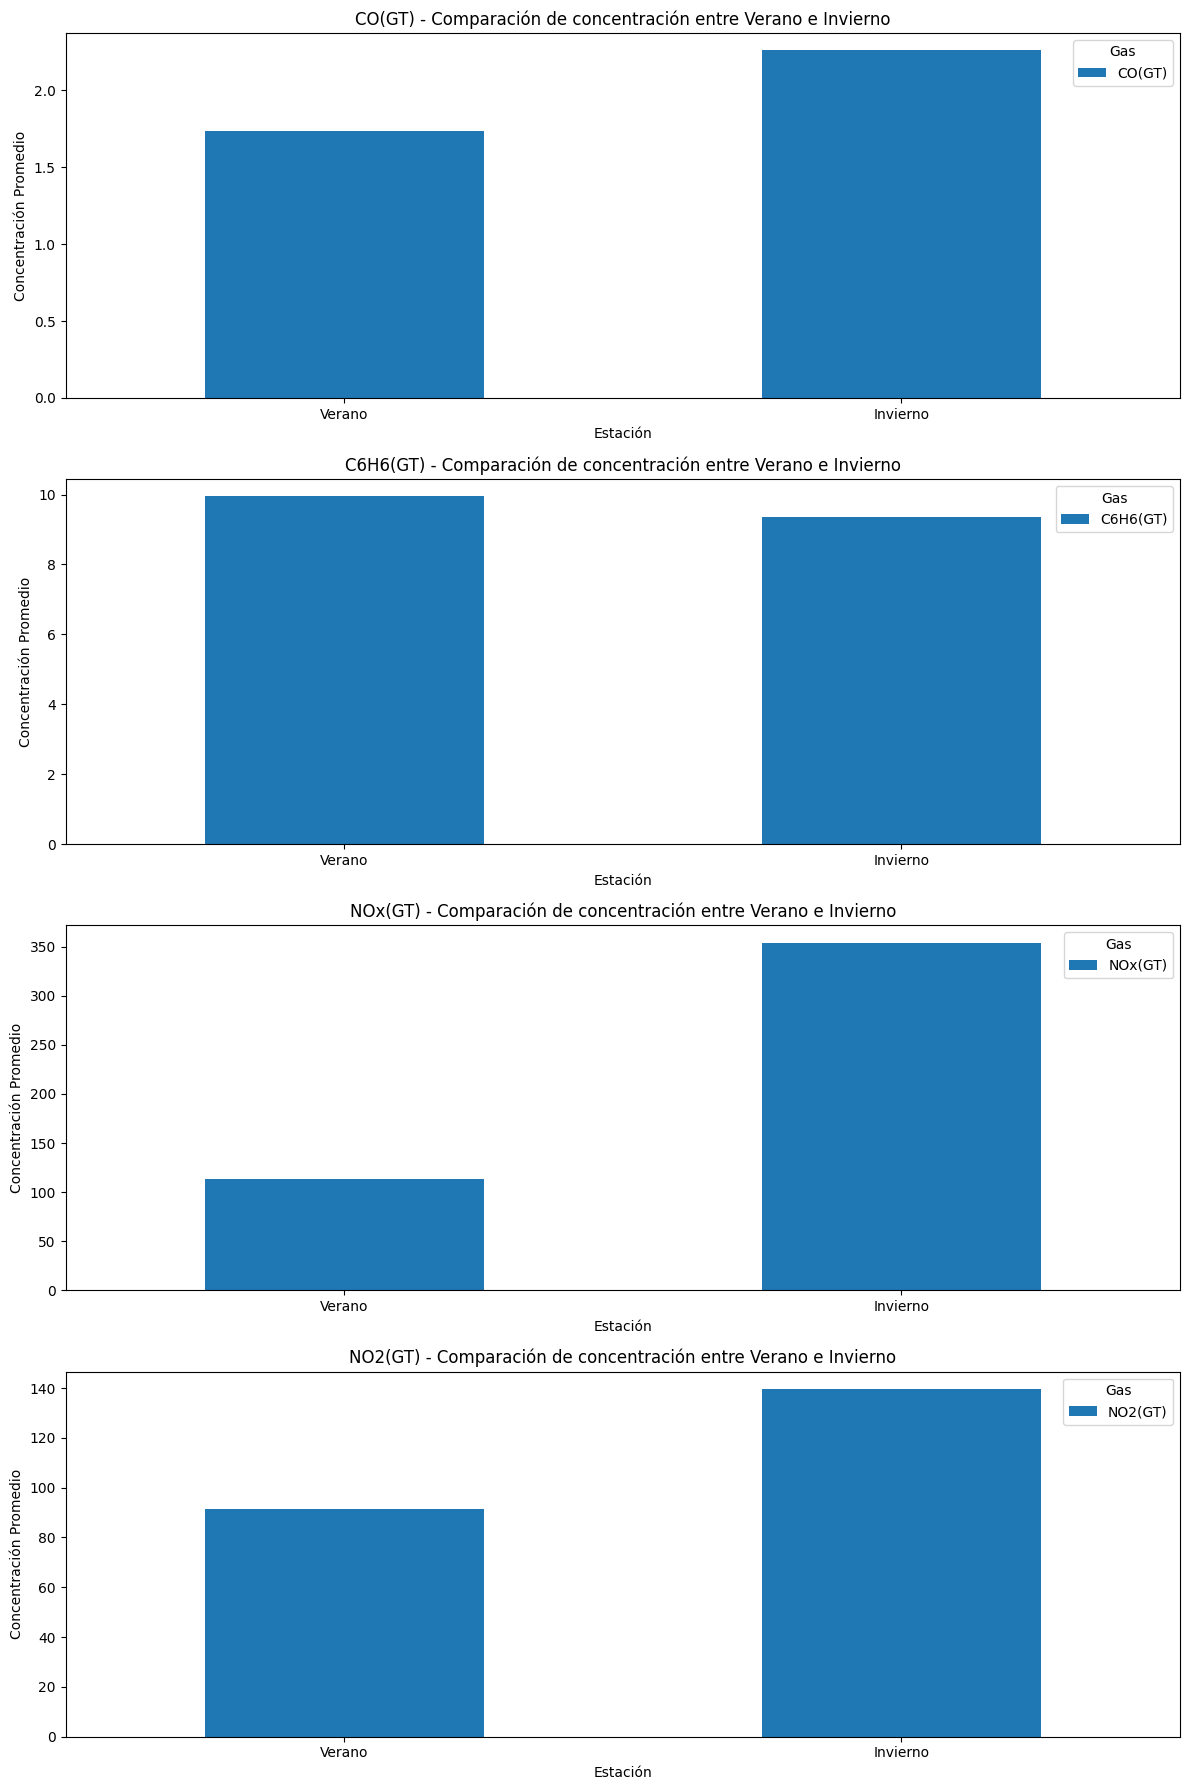

In [9]:
import matplotlib.pyplot as plt

# Filtrar los datos para obtener solo Verano e Invierno
df_verano_invierno = df[df['Estacion'].isin([1, 3])]  # 1 = Verano, 3 = Invierno

# Seleccionar las columnas de gases
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Agrupar por estación y calcular la media de cada gas
df_verano_invierno_grouped = df_verano_invierno.groupby('Estacion')[gases].mean().reset_index()

# Crear un gráfico de barras para comparar Verano e Invierno
fig, axes = plt.subplots(len(gases), 1, figsize=(12, 18))

# Asignar nombres a las estaciones para la leyenda
estaciones_map = {1: 'Verano', 3: 'Invierno'}

for i, gas in enumerate(gases):
    df_verano_invierno_grouped.plot(kind='bar', x='Estacion', y=gas, ax=axes[i], legend=False)
    axes[i].set_title(f'{gas} - Comparación de concentración entre Verano e Invierno')
    axes[i].set_xlabel('Estación')
    axes[i].set_ylabel('Concentración Promedio')
    axes[i].set_xticklabels([estaciones_map[est] for est in df_verano_invierno_grouped['Estacion']], rotation=0)
    
    # Mostrar la leyenda
    axes[i].legend([gas], title='Gas')

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()


# Historia 3:   Los días con temperaturas más altas están asociados con mayores concentraciones de contaminantes como NO2 y NOx.

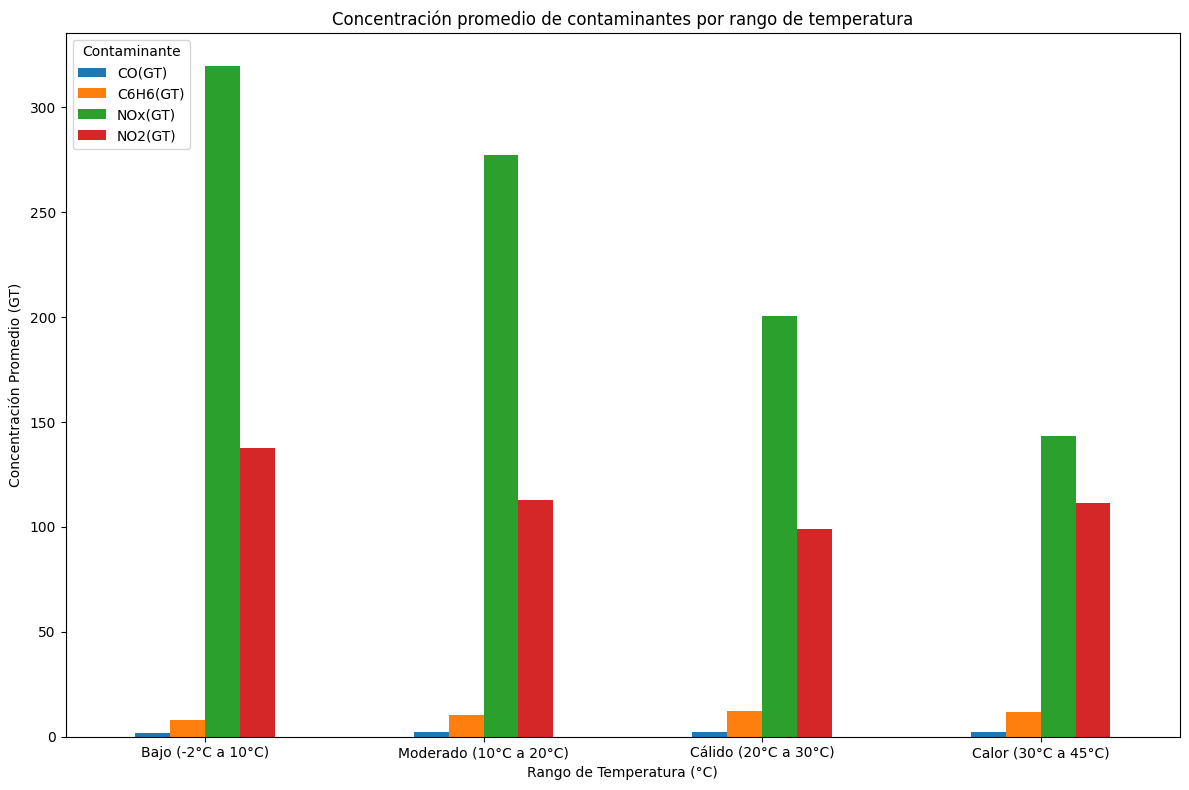

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear una nueva columna que clasifique la temperatura en rangos ajustados
bins = [-2, 10, 20, 30, 45]  # Rango ajustado para tu dataset
labels = ['Bajo (-2°C a 10°C)', 'Moderado (10°C a 20°C)', 'Cálido (20°C a 30°C)', 'Calor (30°C a 45°C)']
df['Temp_Rango'] = pd.cut(df['T'], bins=bins, labels=labels, right=False)

# Agrupar los datos por rango de temperatura y calcular la media de los gases
gases = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
df_temp_grouped = df.groupby('Temp_Rango')[gases].mean().reset_index()

# Crear un gráfico de barras comparando la concentración de los gases por rango de temperatura
fig, ax = plt.subplots(figsize=(12, 8))

df_temp_grouped.plot(kind='bar', x='Temp_Rango', y=gases, ax=ax, legend=True)

# Añadir títulos y etiquetas
ax.set_title('Concentración promedio de contaminantes por rango de temperatura')
ax.set_xlabel('Rango de Temperatura (°C)')
ax.set_ylabel('Concentración Promedio (GT)')
ax.set_xticklabels(df_temp_grouped['Temp_Rango'], rotation=0)
ax.legend(title='Contaminante', loc='upper left')

# Ajustar el diseño
plt.tight_layout()
plt.show()


# outliders 

In [65]:

# Columnas a analizar
columns_to_check = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 
                    'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Iterar sobre las columnas y calcular mínimos y máximos
for col in columns_to_check:
    min_value = df[col].min()
    max_value = df[col].max()
    print(f'\n{col}: Min = {min_value}, Max = {max_value}, Rango = {max_value - min_value}')


# Detectar y eliminar outliers usando IQR
df_outliers = df.copy()  # Copiar el DataFrame para no modificar el original
for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para valores atípicos
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Eliminar outliers
    df_outliers = df_outliers[(df_outliers[col] >= lower_bound) & (df_outliers[col] <= upper_bound)]

    print(f'{col} tiene {df.shape[0] - df_outliers.shape[0]} valores atípicos eliminados.')

# Ahora df_cleaned tiene los datos sin outliers




CO(GT): Min = 0.1, Max = 11.9, Rango = 11.8

C6H6(GT): Min = 0.2, Max = 63.7, Rango = 63.5

NOx(GT): Min = 2.0, Max = 1479.0, Rango = 1477.0

NO2(GT): Min = 2.0, Max = 333.0, Rango = 331.0

PT08.S1(CO): Min = 647.0, Max = 2040.0, Rango = 1393.0

PT08.S2(NMHC): Min = 390.0, Max = 2214.0, Rango = 1824.0

PT08.S3(NOx): Min = 322.0, Max = 2683.0, Rango = 2361.0

PT08.S4(NO2): Min = 551.0, Max = 2775.0, Rango = 2224.0

PT08.S5(O3): Min = 221.0, Max = 2523.0, Rango = 2302.0

T: Min = -1.9, Max = 44.6, Rango = 46.5

RH: Min = 9.2, Max = 88.7, Rango = 79.5

AH: Min = 0.1847, Max = 2.1806, Rango = 1.9959
CO(GT) tiene 22 valores atípicos eliminados.
C6H6(GT) tiene 29 valores atípicos eliminados.
NOx(GT) tiene 61 valores atípicos eliminados.
NO2(GT) tiene 62 valores atípicos eliminados.
PT08.S1(CO) tiene 62 valores atípicos eliminados.
PT08.S2(NMHC) tiene 62 valores atípicos eliminados.
PT08.S3(NOx) tiene 86 valores atípicos eliminados.
PT08.S4(NO2) tiene 86 valores atípicos eliminados.
PT08.S5(

# DATOS NORMALOIZADOS Y SACAR INDICE DE CONTAMINACIÓN 

In [53]:


# Seleccionar las columnas relevantes de gases contaminantes
gases_contaminantes = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
otras_columnas = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Combinar todas las columnas que se van a normalizar
columnas_a_normalizar = gases_contaminantes + otras_columnas

# Convertir las columnas a tipo numérico, manejando errores
df[columnas_a_normalizar] = df[columnas_a_normalizar].apply(pd.to_numeric, errors='coerce')


# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()
df_median_imputed_norm = df.copy()

# Normalizar las columnas seleccionadas
df_median_imputed_norm[columnas_a_normalizar] = scaler.fit_transform(df[columnas_a_normalizar])

# Normalizar las columnas de gases contaminantes
df_median_imputed_norm[gases_contaminantes] = scaler.fit_transform(df[gases_contaminantes])

# Calcular la media de los gases contaminantes para cada fila
df_median_imputed_norm['indeceContaminacion'] = df_median_imputed_norm[gases_contaminantes].mean(axis=1)

# Normalizar el índice usando MinMaxScaler
df_median_imputed_norm['indeceContaminacion'] = scaler.fit_transform(df_median_imputed_norm[['indeceContaminacion']])

# Redondear los valores a 2 decimales
df_median_imputed_norm[columnas_a_normalizar] = df_median_imputed_norm[columnas_a_normalizar].round(2)
df_median_imputed_norm['indeceContaminacion'] = df_median_imputed_norm['indeceContaminacion'].round(2)


# Mostrar el resultado
print(df_median_imputed_norm[['indeceContaminacion']].head())

   indeceContaminacion
0                    0
1                    0
2                    0
3                    0
4                    0


# hacer indice d la calidad del aire, gas x gas 

# Análisis de la Contaminación por Gases y Selección del Mejor Modelo de Clustering

El objetivo de este análisis es determinar cómo varían las concentraciones de los cuatro gases más perjudiciales para la salud, **'CO(GT)'**, **'C6H6(GT)'**, **'NOx(GT)'**, y **'NO2(GT)'**, a lo largo de los días de la semana. Además, se busca seleccionar el mejor modelo de clustering para cada uno de estos gases, con el fin de identificar patrones de contaminación en función de los días de la semana y los niveles de concentración de cada gas.

### Pasos Seguidos:

1. **Selección de Gases**: Se eligieron los siguientes gases debido a su impacto negativo en la salud humana y ambiental:
   - **'CO(GT)'**: Monóxido de carbono
   - **'C6H6(GT)'**: Benceno
   - **'NOx(GT)'**: Óxidos de nitrógeno
   - **'NO2(GT)'**: Dióxido de nitrógeno

2. **Análisis por Día de la Semana**: Para cada gas, se analizaron las concentraciones durante los diferentes días de la semana, con el fin de identificar patrones de contaminación en función de los días.

3. **Método del Codo**: Se aplicó el método del codo para determinar el número óptimo de clusters para cada gas. Este método ayuda a identificar el número ideal de clusters que mejor representa los datos, basándose en la inercia (el error cuadrático medio dentro de los clusters).

4. **Selección del Mejor Modelo de Clustering**: Se evaluaron varios modelos de clustering (como KMeans, DBSCAN, GMM, etc.) para cada gas. El objetivo fue seleccionar el modelo que mejor se ajuste a los datos y que sea capaz de identificar patrones significativos de contaminación a lo largo de los días de la semana.

5. **Evaluación de Modelos**: Para cada gas, se entrenaron los modelos de clustering con los datos correspondientes. Se utilizó el **Silhouette Score** como métrica para evaluar la calidad del clustering. Este score mide cómo de bien están separados los clusters, con valores cercanos a +1 indicando una buena separación.

### Resultado:

A partir del análisis realizado para los cuatro gases y los diferentes días de la semana, se seleccionó el mejor modelo de clustering para cada gas. Esto permitirá identificar de manera más precisa en qué días de la semana y qué periodos del día se presentan mayores niveles de contaminación, con el fin de implementar estrategias de control más efectivas para cada uno de los gases.

### Explicación del Método del Codo:

El **método del codo** es una técnica visual utilizada para seleccionar el número óptimo de clusters en un modelo de clustering como KMeans. Al entrenar el modelo para diferentes valores de K (el número de clusters), se calcula la inercia para cada K. La inercia mide la dispersión dentro de los clusters: un valor bajo indica que los puntos dentro de un cluster están cerca de su centro.

El gráfico resultante muestra cómo cambia la inercia a medida que se aumenta el número de clusters. El "codo" del gráfico es el punto en el que la disminución en la inercia comienza a estabilizarse, lo que indica que agregar más clusters ya no mejora significativamente el modelo. Este punto es considerado como el número óptimo de clusters.

Para cada gas, se realizó este análisis y se determinó que el número óptimo de clusters es **2**. Esto sugiere que los datos de concentración de estos gases pueden agruparse de manera efectiva en dos clusters, lo que ayuda a identificar patrones de contaminación en diferentes días de la semana.

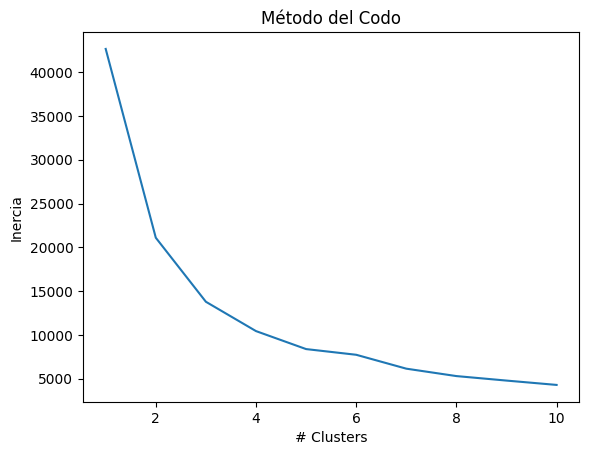

Número óptimo de clusters: 2


In [54]:

variable_X_CO = df[['CO(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_CO, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')


# **Modelos de clustering**
### **Definición de modelos de clustering**  
Se define un diccionario que contiene cinco modelos de clustering:  
- **KMeans**  
- **MeanShift**  
- **Gaussian Mixture Model (GMM)**  
- **DBSCAN**  
- **Agglomerative Clustering**  

Cada modelo se almacena con su correspondiente instancia de clase.


### **Definición de hiperparámetros para cada modelo**  
Se crea un diccionario de hiperparámetros para cada algoritmo de clustering.  
Incluye diversas configuraciones como:  
- Número de clusters  
- Algoritmos de inicialización  
- Número máximo de iteraciones  
- Métricas de distancia  
- Parámetros de inicialización  
- Semillas aleatorias  

### **Scoring basado en Silhouette Score**  
Se define una métrica de evaluación utilizando el **Silhouette Score**, que mide la cohesión y separación de los clusters usando la distancia euclidiana.  

### **Función para evaluar modelos de clustering**  
Se implementa la función `evaluar_modelo_clustering`, que:  
1. Crea un pipeline con un escalador de datos (**MinMaxScaler**) y el modelo de clustering.  
2. Realiza la búsqueda de hiperparámetros óptimos usando **GridSearchCV**, con:  
   - Validación cruzada de 5 particiones  
   - Evaluación basada en la métrica Silhouette Score  
   - Uso de múltiples núcleos en paralelo  
3. Entrena el modelo con los datos de entrada.  
4. Retorna el mejor estimador encontrado.  


### **Preparación de los datos**  
Se seleccionan las columnas relevantes del DataFrame:  
- **CO(GT)**: Concentración de monóxido de carbono  
- **DiaSemana**: Día de la semana codificado  


### **Evaluación de los modelos de clustering**  
Se recorre cada modelo de clustering definido, llamando a la función de evaluación para obtener el mejor modelo en función de los parámetros evaluados.  


### **Cálculo de métricas de evaluación**  
Para cada modelo entrenado:  
1. Se obtienen las etiquetas de los clusters predichos.  
2. Se calcula el **Silhouette Score** para medir la calidad del clustering.  
3. Si existen etiquetas reales, se calcula el **Rand Index**, que mide la similitud entre la agrupación obtenida y la agrupación real.  
4. Se extraen e imprimen los hiperparámetros seleccionados.  


### **Visualización de los resultados**  
Se generan gráficos de dispersión utilizando **Seaborn**, donde se visualizan los clusters obtenidos con cada modelo en función de las características seleccionadas.  
Se configuran elementos visuales como:  
- Paleta de colores  
- Transparencia y bordes  
- Títulos y etiquetas de los ejes  


### Conclusión

Se utilizan las métricas Silhouette Score y Rand Index para evaluar los modelos de clustering por las siguientes razones:

Silhouette Score: Permite medir la calidad del clustering evaluando la cohesión interna de cada cluster y la separación entre clusters, ayudando a determinar cuán bien están definidos los grupos.

Rand Index: Compara las etiquetas generadas por el modelo con las etiquetas reales (si están disponibles), proporcionando una medida de la similitud entre ambas clasificaciones y evaluando la exactitud del modelo.

El uso combinado de estas métricas ayuda a seleccionar el modelo de clustering más adecuado según la estructura subyacente de los datos.

In [55]:

clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  
        'model__init': ['k-means++', 'random'],          
        'model__max_iter': [50, 200, 300, 500, 1000],                        
        'model__tol': [1e-4, 1e-5, 1e-8],                           
        'model__algorithm': ['lloyd', 'elkan'],   
        'model__n_init': [10, 20, 30, 40],                           
        'model__random_state': [42, 100, 1],                             
        'model__verbose': [0, 1, 2],  
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0, 3.0, 4.0],             
        'model__bin_seeding': [True, False],                
        'model__min_bin_freq': [1, 5, 10],                      
        'model__cluster_all': [True, False],            
        'model__max_iter': [300, 500, 1000],                  
        'model__n_jobs': [1, -1]
    },
    'GMM': { 
        'model__n_components': [optimal_clusters],                  
        'model__covariance_type': ['full', 'tied', 'diag', 'spherical'],  
        'model__tol': [1e-3, 1e-4, 1e-5],                      
        'model__reg_covar': [1e-6, 1e-5, 1e-4, 1e-3],                
        'model__max_iter': [100, 200, 300, 400],                   
        'model__n_init': [1, 5, 10],                           
        'model__init_params': ['kmeans', 'random'],            
        'model__random_state': [42, 100, 1],
        'model__warm_start': [True, False]
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0, 1.5],
        'model__min_samples': [5, 10, 20, 30],
        'model__metric': ['euclidean', 'manhattan', 'minkowski', 'cosine'],
        'model__metric_params': [None, {'w': [1, 2, 3]}],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [30,  40, 50],
        'model__p': [2, 3],                                   
        'model__n_jobs': [-1, 1],                              
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan', 'cosine'], 
        'model__memory': [None],                       
        'model__connectivity': [None, 'knn'],                  
        'model__linkage': ['ward', 'complete', 'average', 'single'],  
        'model__distance_threshold': [None, 5, 10],           
    }

}

# Paso 3: Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Paso 4: Función para evaluar modelos de clustering
def evaluar_modelo_clustering(model, param_grid, X):
    pipeline = Pipeline(steps=[ 
        ('scaler', MinMaxScaler()), 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  # Usamos Silhouette Score como métrica
        cv=5,  # Sin partición (compatible con clustering)
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Paso 5: Preparar los datos
X = df[['CO(GT)','DiaSemana']]  # Seleccionar columnas relevantes

# Paso 6: Evaluar modelos
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name}...")
    mejores_modelos[model_name] = evaluar_modelo_clustering(
        model=model,
        param_grid=param_grids[model_name],
        X=X  # Pasamos el DataFrame directamente
    )

# Paso 7: Evaluar con Silhouette Score y mostrar hiperparámetros
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    score = silhouette_score(X, labels)

    y_true = df['CO(GT)']  
    v_measure = v_measure_score(y_true, labels)

    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    # Imprimir resultados
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {score}")
    print(f"V-Measure: {v_measure:.2f}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X['CO(GT)'], y=X['DiaSemana'], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering - Silhouette Score: {score:.2f} | V-Measure: {v_measure:.2f}")
    plt.xlabel("CO(GT)")
    plt.ylabel("DiaSemana (Codificado)")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()



Evaluando KMeans...
Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


KeyboardInterrupt: 


Evaluando KMeans con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando MeanShift con PCA...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Evaluando GMM con PCA...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

Evaluando DBSCAN con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando AgglomerativeClustering con PCA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Modelo: KMeans
Silhouette Score: 0.4530425302963163
V-Measure: 0.018060297311380945
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 50
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 0.0001
  verbose: 0


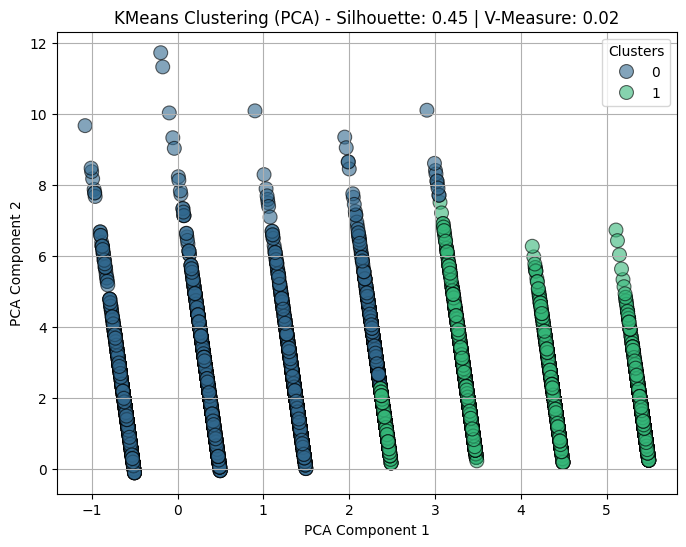


Modelo: MeanShift
Silhouette Score: 0.5023279316853342
V-Measure: 0.42672364792036616
Mejores hiperparámetros seleccionados:
  bandwidth: 0.5
  bin_seeding: True
  cluster_all: True
  max_iter: 300
  min_bin_freq: 1
  n_jobs: 1
  seeds: None


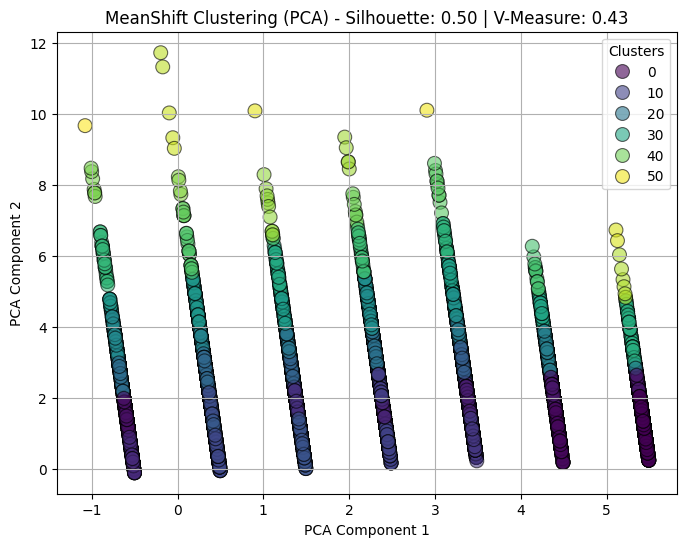


Modelo: GMM
Silhouette Score: 0.30520697714159295
V-Measure: 0.0051014683605543594
Mejores hiperparámetros seleccionados:
  covariance_type: full
  init_params: kmeans
  max_iter: 100
  means_init: None
  n_components: 2
  n_init: 1
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: True
  weights_init: None


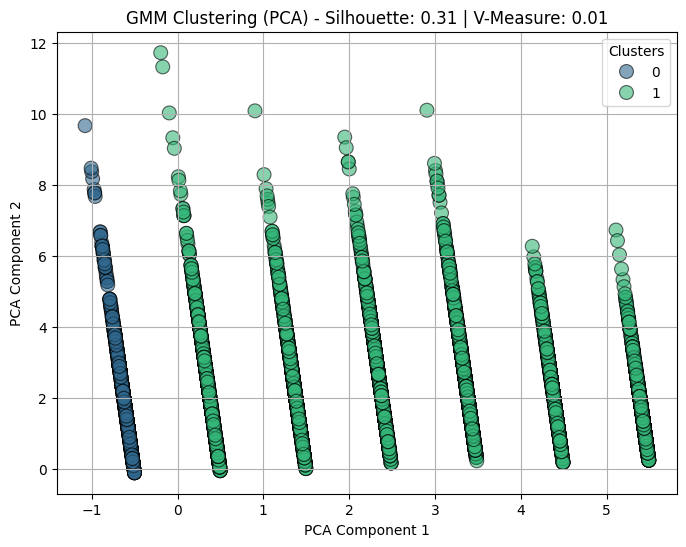


Modelo: DBSCAN
Silhouette Score: 0.22713181477210517
V-Measure: 0.049492799294809466
Mejores hiperparámetros seleccionados:
  algorithm: auto
  eps: 0.3
  leaf_size: 30
  metric: euclidean
  metric_params: None
  min_samples: 5
  n_jobs: -1
  p: 2


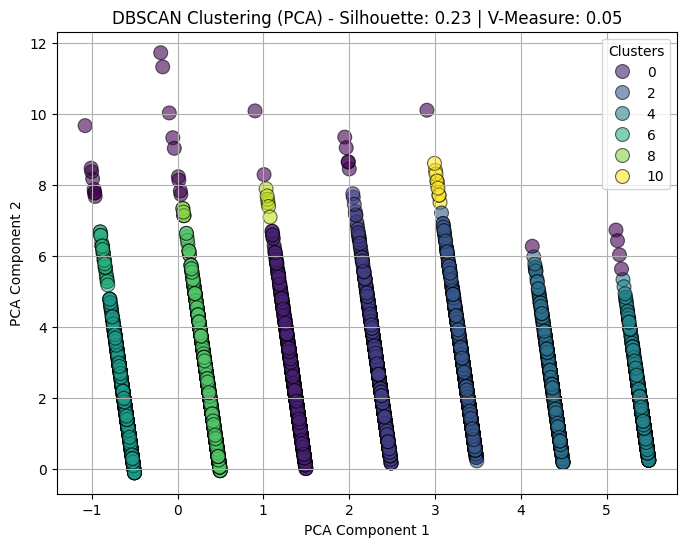


Modelo: AgglomerativeClustering
Silhouette Score: 0.3891109069492444
V-Measure: 0.05791998289808605
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: auto
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


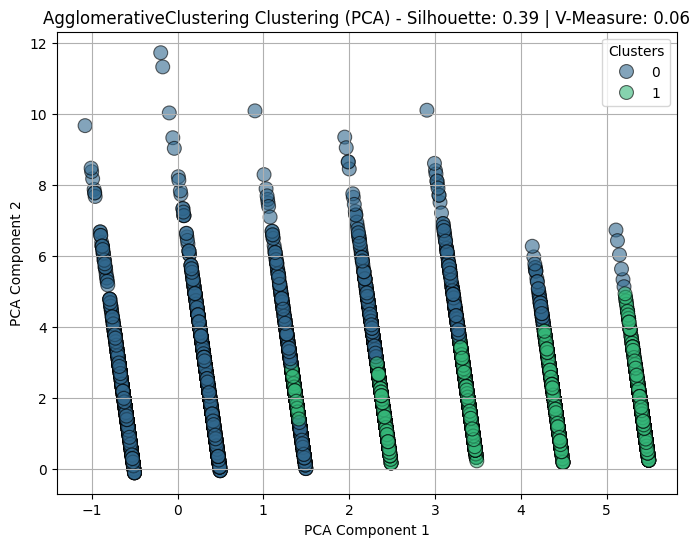

In [ ]:

# Definir modelos de clustering
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

# Definir parámetros de búsqueda
param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  
        'model__init': ['k-means++', 'random'],          
        'model__max_iter': [50, 200, 300],                        
        'model__tol': [1e-4, 1e-5],                           
        'model__algorithm': ['lloyd', 'elkan'],   
        'model__n_init': [10, 20],                           
        'model__random_state': [42, 100],                             
        'model__verbose': [0, 1],  
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0],             
        'model__bin_seeding': [True, False],             
        'model__min_bin_freq': [1, 5],                      
        'model__max_iter': [300, 500],                  
        'model__n_jobs': [1, -1]
    },
    'GMM': { 
        'model__n_components': [optimal_clusters],                  
        'model__covariance_type': ['full', 'tied'],  
        'model__tol': [1e-3, 1e-4],                      
        'model__reg_covar': [1e-6, 1e-5],                
        'model__max_iter': [100, 200],                   
        'model__n_init': [1, 5],                           
        'model__init_params': ['kmeans', 'random'],            
        'model__random_state': [42, 100],
        'model__warm_start': [True, False]
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10],
        'model__metric': ['euclidean', 'manhattan'],
        'model__algorithm': ['auto', 'ball_tree'],
        'model__leaf_size': [30, 50],
        'model__p': [2, 3],                                   
        'model__n_jobs': [-1, 1],                              
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__linkage': ['ward', 'complete'],  
        'model__distance_threshold': [None, 5],           
    }
}

# Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Función para evaluar modelos de clustering con PCA
def evaluar_modelo_clustering_con_pca(model, param_grid, X, n_components=2):
    pipeline = Pipeline(steps=[ 
        ('scaler', MinMaxScaler()), 
        ('pca', PCA(n_components=n_components)), 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  
        cv=5,  
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Preparar los datos
X = df[['CO(GT)', 'DiaSemana']]  # Seleccionar columnas relevantes

# Evaluar modelos con PCA
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name} con PCA...")
    mejores_modelos[model_name] = evaluar_modelo_clustering_con_pca(
        model=model,
        param_grid=param_grids[model_name],
        X=X
    )

# Evaluar con Silhouette Score, V-Measure y visualizar resultados
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    silhouette = silhouette_score(X, labels)
    
    y_true = df['CO(GT)']  
    v_measure = v_measure_score(y_true, labels)

    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {silhouette:}")
    print(f"V-Measure: {v_measure:}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering con PCA
    X_pca = best_model.named_steps['pca'].transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering (PCA) - Silhouette: {silhouette:.2f} | V-Measure: {v_measure:.2f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()


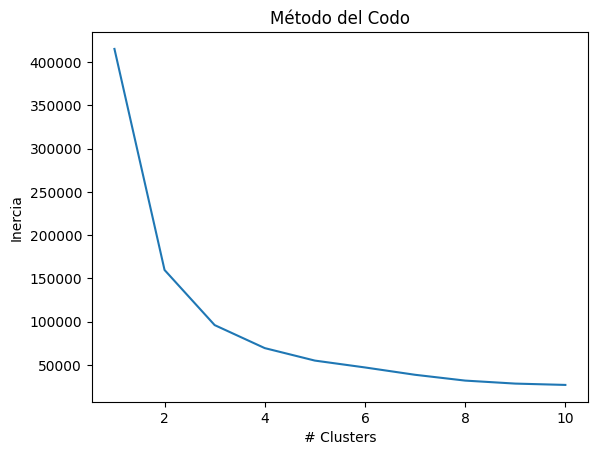

Número óptimo de clusters: 2


In [68]:

variable_X_CO = df[['C6H6(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_CO, 1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')



Evaluando KMeans con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando MeanShift con PCA...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Evaluando GMM con PCA...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

Evaluando DBSCAN con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando AgglomerativeClustering con PCA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Modelo: KMeans
Silhouette Score: 0.5584720467594496
V-Measure: 0.19771273274392798
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 50
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 0.0001
  verbose: 0


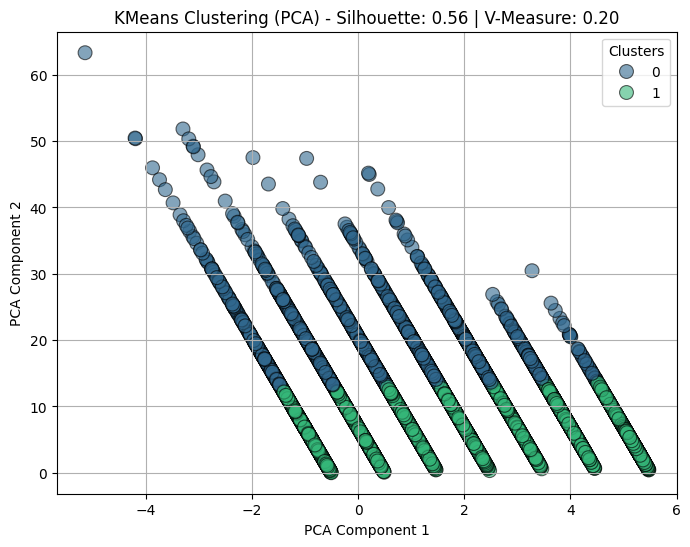


Modelo: MeanShift
Silhouette Score: 0.5147813411781561
V-Measure: 0.6453365744269998
Mejores hiperparámetros seleccionados:
  bandwidth: 0.5
  bin_seeding: True
  cluster_all: True
  max_iter: 300
  min_bin_freq: 1
  n_jobs: 1
  seeds: None


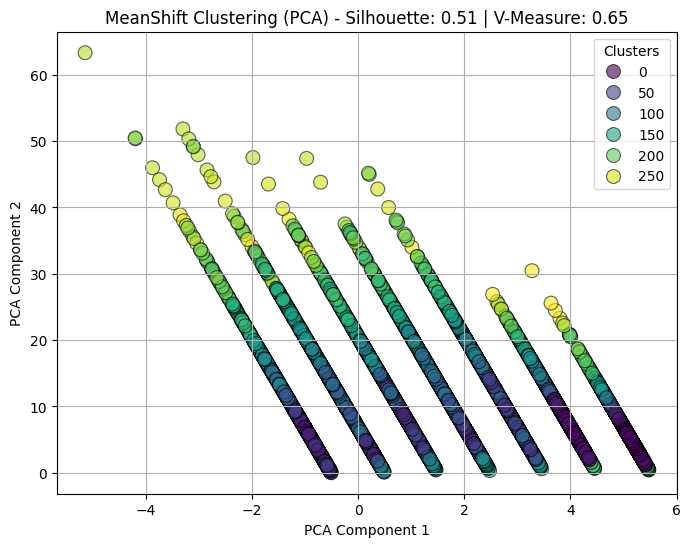


Modelo: GMM
Silhouette Score: 0.10998675544535373
V-Measure: 0.010883933084605791
Mejores hiperparámetros seleccionados:
  covariance_type: full
  init_params: kmeans
  max_iter: 100
  means_init: None
  n_components: 2
  n_init: 1
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: True
  weights_init: None


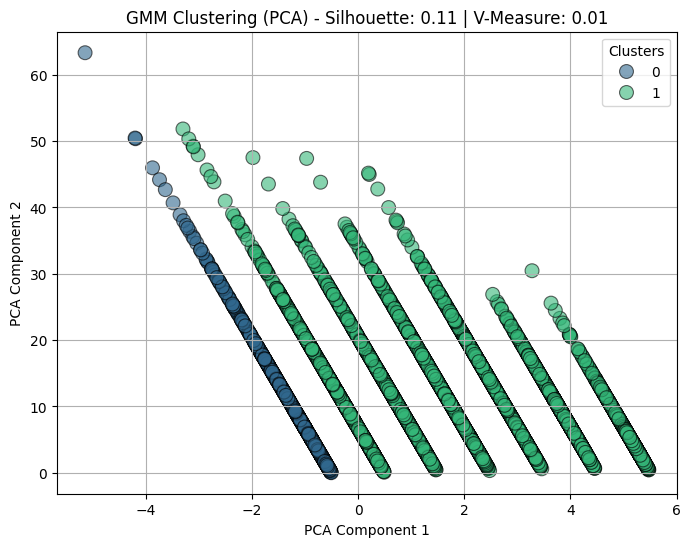


Modelo: DBSCAN
Silhouette Score: -0.2533459469654646
V-Measure: 0.14967460166358454
Mejores hiperparámetros seleccionados:
  algorithm: auto
  eps: 0.3
  leaf_size: 30
  metric: euclidean
  metric_params: None
  min_samples: 5
  n_jobs: -1
  p: 2


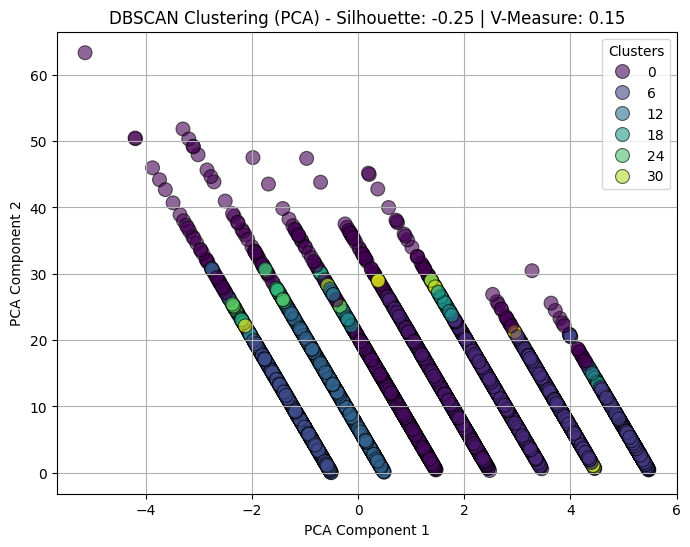


Modelo: AgglomerativeClustering
Silhouette Score: 0.5341196603667919
V-Measure: 0.18802553485852105
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: auto
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


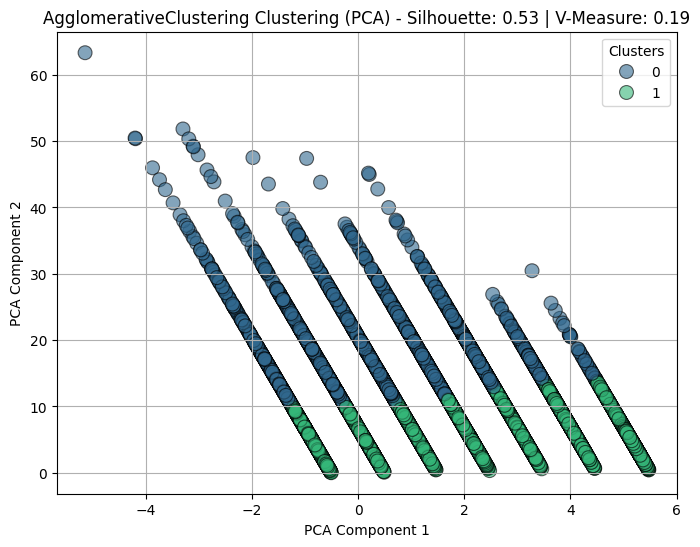

In [70]:

# Definir modelos de clustering
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

# Definir parámetros de búsqueda
param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  
        'model__init': ['k-means++', 'random'],          
        'model__max_iter': [50, 200, 300],                        
        'model__tol': [1e-4, 1e-5],                           
        'model__algorithm': ['lloyd', 'elkan'],   
        'model__n_init': [10, 20],                           
        'model__random_state': [42, 100],                             
        'model__verbose': [0, 1],  
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0],             
        'model__bin_seeding': [True, False],             
        'model__min_bin_freq': [1, 5],                      
        'model__max_iter': [300, 500],                  
        'model__n_jobs': [1, -1]
    },
    'GMM': { 
        'model__n_components': [optimal_clusters],                  
        'model__covariance_type': ['full', 'tied'],  
        'model__tol': [1e-3, 1e-4],                      
        'model__reg_covar': [1e-6, 1e-5],                
        'model__max_iter': [100, 200],                   
        'model__n_init': [1, 5],                           
        'model__init_params': ['kmeans', 'random'],            
        'model__random_state': [42, 100],
        'model__warm_start': [True, False]
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10],
        'model__metric': ['euclidean', 'manhattan'],
        'model__algorithm': ['auto', 'ball_tree'],
        'model__leaf_size': [30, 50],
        'model__p': [2, 3],                                   
        'model__n_jobs': [-1, 1],                              
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__linkage': ['ward', 'complete'],  
        'model__distance_threshold': [None, 5],           
    }
}

# Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Función para evaluar modelos de clustering con PCA
def evaluar_modelo_clustering_con_pca(model, param_grid, X, n_components=2):
    pipeline = Pipeline(steps=[ 
        ('scaler', MinMaxScaler()), 
        ('pca', PCA(n_components=n_components)), 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  
        cv=5,  
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Preparar los datos
X = df[['C6H6(GT)', 'DiaSemana']]  # Seleccionar columnas relevantes

# Evaluar modelos con PCA
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name} con PCA...")
    mejores_modelos[model_name] = evaluar_modelo_clustering_con_pca(
        model=model,
        param_grid=param_grids[model_name],
        X=X
    )

# Evaluar con Silhouette Score, V-Measure y visualizar resultados
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    silhouette = silhouette_score(X, labels)
    
    y_true = df['C6H6(GT)']  
    v_measure = v_measure_score(y_true, labels)

    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {silhouette:}")
    print(f"V-Measure: {v_measure:}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering con PCA
    X_pca = best_model.named_steps['pca'].transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering (PCA) - Silhouette: {silhouette:.2f} | V-Measure: {v_measure:.2f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()


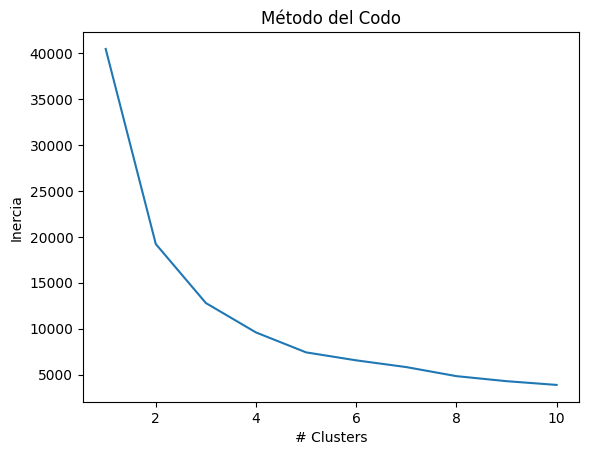

Número óptimo de clusters: 2


In [66]:

variable_X_CO = df_outliers[['CO(GT)','DiaSemana']]

# Función que calcula y dibuja el gráfico para utilizar el método del codo.
def elbow_method_kmeans(data, range_a, range_b):
    inercia = []
    for i in range(range_a, range_b):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        inercia.append(kmeans.inertia_)
    
    # Gráfico del codo
    plt.plot(range(range_a, range_b), inercia)
    plt.xlabel('# Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.show()

    # Cálculo del cambio en la inercia
    diffs = np.diff(inercia)
    optimal_k = np.argmin(diffs) + range_a + 1  # +1 porque np.diff reduce la longitud de la lista
    return optimal_k

# Determinar el número óptimo de clusters
optimal_clusters = elbow_method_kmeans(variable_X_CO,1, 11)
print(f'Número óptimo de clusters: {optimal_clusters}')



Evaluando KMeans con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando MeanShift con PCA...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Evaluando GMM con PCA...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

Evaluando DBSCAN con PCA...
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Evaluando AgglomerativeClustering con PCA...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Modelo: KMeans
Silhouette Score: 0.4630840262974555
V-Measure: 0.0071566846449005826
Mejores hiperparámetros seleccionados:
  algorithm: lloyd
  copy_x: True
  init: k-means++
  max_iter: 50
  n_clusters: 2
  n_init: 10
  random_state: 42
  tol: 0.0001
  verbose: 0


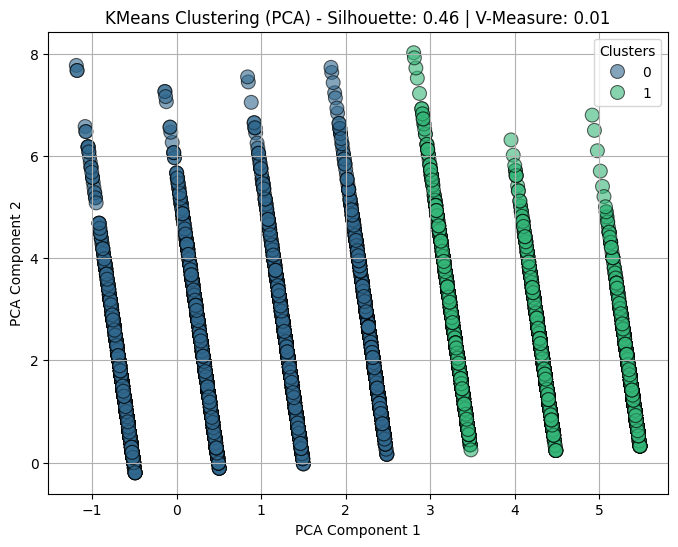


Modelo: MeanShift
Silhouette Score: 0.5027291434690975
V-Measure: 0.4230875918993725
Mejores hiperparámetros seleccionados:
  bandwidth: 0.5
  bin_seeding: True
  cluster_all: True
  max_iter: 300
  min_bin_freq: 1
  n_jobs: 1
  seeds: None


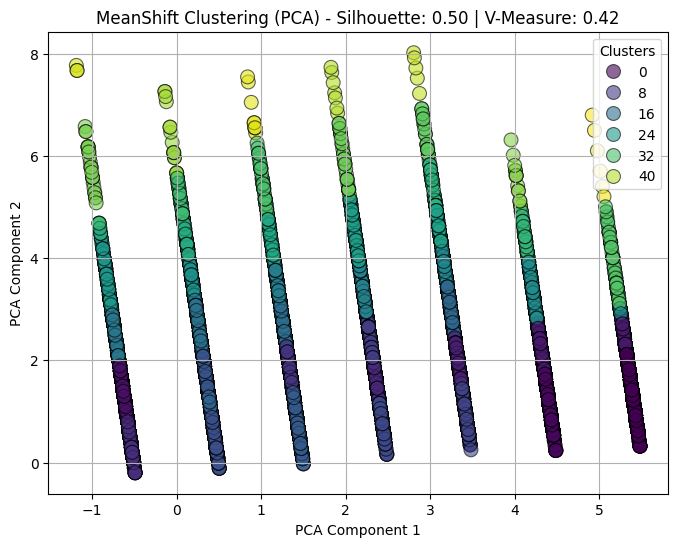


Modelo: GMM
Silhouette Score: 0.41817127313558305
V-Measure: 0.05144781571474489
Mejores hiperparámetros seleccionados:
  covariance_type: full
  init_params: kmeans
  max_iter: 100
  means_init: None
  n_components: 2
  n_init: 1
  precisions_init: None
  random_state: 42
  reg_covar: 1e-06
  tol: 0.001
  verbose: 0
  verbose_interval: 10
  warm_start: True
  weights_init: None


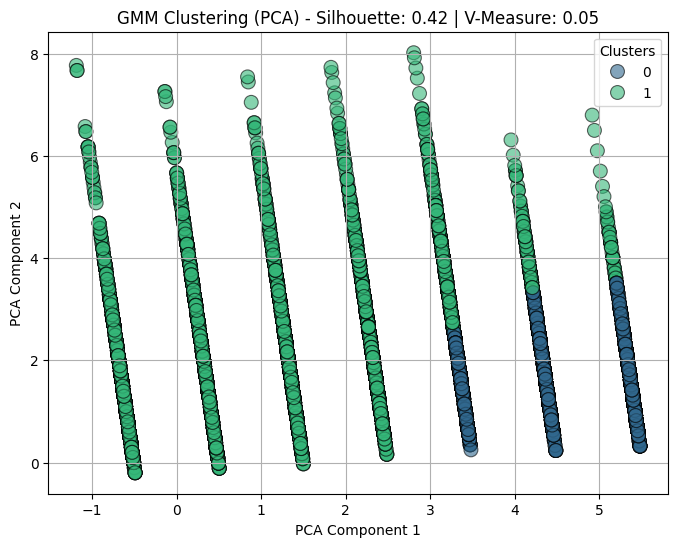


Modelo: DBSCAN
Silhouette Score: 0.23376632410725115
V-Measure: 0.03873266855925163
Mejores hiperparámetros seleccionados:
  algorithm: auto
  eps: 0.3
  leaf_size: 30
  metric: euclidean
  metric_params: None
  min_samples: 5
  n_jobs: -1
  p: 2


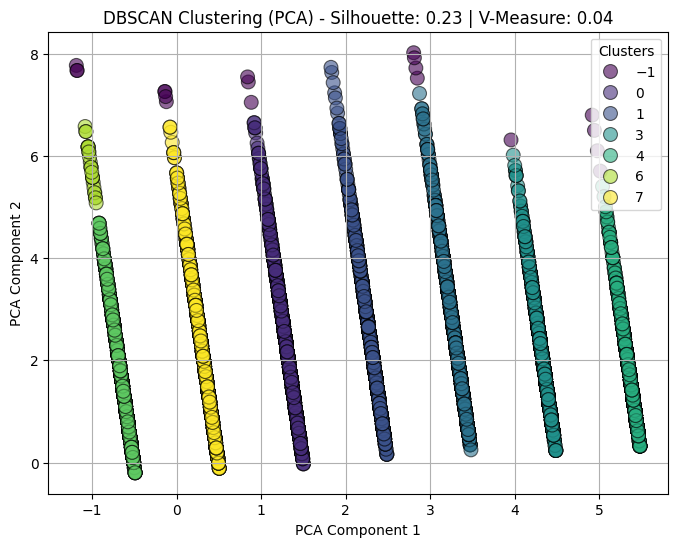


Modelo: AgglomerativeClustering
Silhouette Score: 0.4456652898610523
V-Measure: 0.02910233641837909
Mejores hiperparámetros seleccionados:
  compute_distances: False
  compute_full_tree: auto
  connectivity: None
  distance_threshold: None
  linkage: ward
  memory: None
  metric: euclidean
  n_clusters: 2


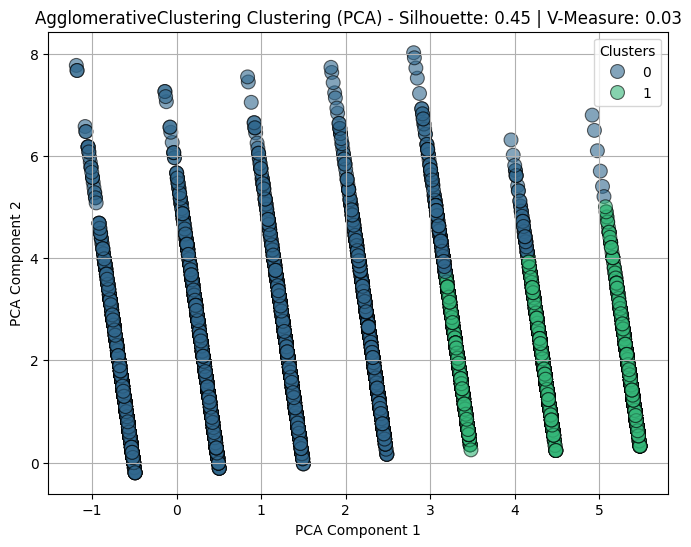

In [67]:

# Definir modelos de clustering
clustering_models = {
    'KMeans': KMeans(),
    'MeanShift': MeanShift(),
    'GMM': GaussianMixture(),
    'DBSCAN': DBSCAN(),
    'AgglomerativeClustering': AgglomerativeClustering()
}

# Definir parámetros de búsqueda
param_grids = {
    'KMeans': {
        'model__n_clusters': [optimal_clusters],                  
        'model__init': ['k-means++', 'random'],          
        'model__max_iter': [50, 200, 300],                        
        'model__tol': [1e-4, 1e-5],                           
        'model__algorithm': ['lloyd', 'elkan'],   
        'model__n_init': [10, 20],                           
        'model__random_state': [42, 100],                             
        'model__verbose': [0, 1],  
    },
    'MeanShift': {
        'model__bandwidth': [0.5, 1.0, 2.0],             
        'model__bin_seeding': [True, False],             
        'model__min_bin_freq': [1, 5],                      
        'model__max_iter': [300, 500],                  
        'model__n_jobs': [1, -1]
    },
    'GMM': { 
        'model__n_components': [optimal_clusters],                  
        'model__covariance_type': ['full', 'tied'],  
        'model__tol': [1e-3, 1e-4],                      
        'model__reg_covar': [1e-6, 1e-5],                
        'model__max_iter': [100, 200],                   
        'model__n_init': [1, 5],                           
        'model__init_params': ['kmeans', 'random'],            
        'model__random_state': [42, 100],
        'model__warm_start': [True, False]
    },
    'DBSCAN': {
        'model__eps': [0.3, 0.5, 1.0],
        'model__min_samples': [5, 10],
        'model__metric': ['euclidean', 'manhattan'],
        'model__algorithm': ['auto', 'ball_tree'],
        'model__leaf_size': [30, 50],
        'model__p': [2, 3],                                   
        'model__n_jobs': [-1, 1],                              
    },
    'AgglomerativeClustering': {
        'model__n_clusters':  [optimal_clusters],                      
        'model__metric': ['euclidean', 'manhattan'], 
        'model__linkage': ['ward', 'complete'],  
        'model__distance_threshold': [None, 5],           
    }
}

# Definir el scoring basado en Silhouette Score
silhouette_scorer = make_scorer(silhouette_score, metric='euclidean')

# Función para evaluar modelos de clustering con PCA
def evaluar_modelo_clustering_con_pca(model, param_grid, X, n_components=2):
    pipeline = Pipeline(steps=[ 
        ('scaler', MinMaxScaler()), 
        ('pca', PCA(n_components=n_components)), 
        ('model', model)            
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,  
        cv=5,  
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X)
    return grid_search.best_estimator_

# Preparar los datos
X = df_outliers[['CO(GT)', 'DiaSemana']]  # Seleccionar columnas relevantes

# Evaluar modelos con PCA
mejores_modelos = {}
for model_name, model in clustering_models.items():
    print(f"\nEvaluando {model_name} con PCA...")
    mejores_modelos[model_name] = evaluar_modelo_clustering_con_pca(
        model=model,
        param_grid=param_grids[model_name],
        X=X
    )

# Evaluar con Silhouette Score, V-Measure y visualizar resultados
for model_name, best_model in mejores_modelos.items():
    labels = best_model.named_steps['model'].fit_predict(X)
    silhouette = silhouette_score(X, labels)
    
    y_true = df_outliers['CO(GT)']  
    v_measure = v_measure_score(y_true, labels)

    # Extraer los hiperparámetros seleccionados
    best_params = best_model.named_steps['model'].get_params()
    
    print(f"\nModelo: {model_name}")
    print(f"Silhouette Score: {silhouette:}")
    print(f"V-Measure: {v_measure:}")
    print("Mejores hiperparámetros seleccionados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualización del clustering con PCA
    X_pca = best_model.named_steps['pca'].transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis", s=100, alpha=0.6, edgecolor='k')
    plt.title(f"{model_name} Clustering (PCA) - Silhouette: {silhouette:.2f} | V-Measure: {v_measure:.2f}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Clusters", loc="upper right")
    plt.grid(True)
    plt.show()
